<a href="https://colab.research.google.com/github/Jaybhatt216/EIT/blob/main/topic_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing (NLP)
## TOPIC MODELLING ~ 201
* TextHero: TF-IDF
* Gensim: Doc2Vec



## SETUP ~ the most fun part, importing random things...

In [9]:
#!pip install texthero

In [10]:
# Import Packages
import pandas as pd
import sqlite3
import texthero as hero
from texthero import preprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Establish connection to sqlite database to manipulate an SQL file type
# update the file url before you run this section
conn = sqlite3.connect("/content/AllPrintings.sqlite")

# load the SQL data into a pandas DataFrame using SQL statement
df = pd.read_sql("SELECT * FROM cards", conn)

In [12]:
# SELECT DISTINCT columns from cards table and load into a pandas DataFrame using SQL statement
df = pd.read_sql("""SELECT DISTINCT name, text, convertedManaCost, power, toughness, keywords
                    FROM cards 
                    WHERE borderColor ='black' and colorIdentity = 'G'""", conn)

### EDA on loaded PD df

In [13]:
# view head of the Dataframe you just loaded
df.head(3)

,name,text,convertedManaCost,power,toughness,keywords
0,Abundance,"If you would draw a card, you may instead choo...",4.0,None,None,None
1,Aggressive Urge,Target creature gets +1/+1 until end of turn.\...,2.0,None,None,None
2,Avatar of Might,If an opponent controls at least four more cre...,8.0,8,8,Trample


In [14]:
df.shape

(3165, 6)

## 1. TextHERO! ~ TFIDF
use Text Hero to preprocess the desired column with text data before vectorizing it

In [15]:
# use the inbuilt methods in TextHero to create 
# a pipeline you can use to clean your text data from the DF
custom_pipeline = [preprocessing.fillna,
                   #preprocessing.lowercase,
                   #preprocessing.remove_digits,
                   #preprocessing.remove_punctuation(),
                   preprocessing.remove_whitespace,
                   #preprocessing.remove_stopwords(),
                   preprocessing.remove_diacritics
                   #preprocessing.remove_brackets,
                  ]

# use this line to create a new column receiving and holding preprocessed text
# that you feed into the pipeline above
df['clean_text'] = hero.clean(df['text'], custom_pipeline)

# this part can be included within the pipeline as {"#preprocessing.remove_brackets"}
# refer to TextHero documentation online
df['clean_text'] = [n.replace('{','') for n in df['clean_text']]
df['clean_text'] = [n.replace('}','') for n in df['clean_text']]
df['clean_text'] = [n.replace('(','') for n in df['clean_text']]
df['clean_text'] = [n.replace(')','') for n in df['clean_text']]

In [16]:
# use inbuilt TextHERO tfidf vectorizer to create a tfidf vectors from the clean_text data
# you concurrently store the tfidf values in a new column
df['tfidf'] = (hero.tfidf(df['clean_text'], max_features=3000))

In [17]:
# preview the df and witness the greatness you possess for creating vectors with one click
df.head(2)

,name,text,convertedManaCost,power,toughness,keywords,clean_text,tfidf
0,Abundance,"If you would draw a card, you may instead choo...",4.0,None,None,None,"If you would draw a card, you may instead choo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Aggressive Urge,Target creature gets +1/+1 until end of turn.\...,2.0,None,None,None,Target creature gets +1/+1 until end of turn. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## 2. GENSIM ~ Doc2Vec
we use the same `clean_text` column from the section above to generate a different set of vectors using GENSIM 

In [18]:
#tokenize and tag the card text
# start by create TaggedDocuments that gensim uses to generate vectors
card_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df.clean_text)]

#preview two documents (GENSIM TaggedDocuments)
card_docs[:2]

[TaggedDocument(words=['If', 'you', 'would', 'draw', 'a', 'card,', 'you', 'may', 'instead', 'choose', 'land', 'or', 'nonland', 'and', 'reveal', 'cards', 'from', 'the', 'top', 'of', 'your', 'library', 'until', 'you', 'reveal', 'a', 'card', 'of', 'the', 'chosen', 'kind.', 'Put', 'that', 'card', 'into', 'your', 'hand', 'and', 'put', 'all', 'other', 'cards', 'revealed', 'this', 'way', 'on', 'the', 'bottom', 'of', 'your', 'library', 'in', 'any', 'order.'], tags=[0]),
 TaggedDocument(words=['Target', 'creature', 'gets', '+1/+1', 'until', 'end', 'of', 'turn.', 'Draw', 'a', 'card.'], tags=[1])]

In [19]:
# instantiate a gensim model and define parameters such as the vector_size, epochs etc
# check gensim website for documentation on how to use it's embedding tools
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)

#build vocabulary set
model.build_vocab(card_docs)

In [20]:
#train GENSIM model
model.train(card_docs, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

In [21]:
#generate vectors for each document and save as an array of arrays
card2vec = [model.infer_vector((df['clean_text'][i].split(' '))) 
            for i in range(0,len(df['clean_text']))]
card2vec[:2]

[array([ 9.4213560e-02, -2.0128001e-01, -1.0156276e-01,  5.0588065e-01,
        -5.3584749e-01,  1.3596031e-01,  3.6930926e-02, -4.5225403e-01,
         6.0392624e-01, -3.2043701e-01, -6.8760782e-02, -1.0798643e-01,
         9.4656065e-02, -1.0748543e-01, -5.4555750e-01,  1.0998349e-01,
        -1.9639756e-01, -1.1455928e-01,  1.7611147e-01,  2.7909791e-01,
         2.0812845e-01, -1.1519602e-01, -5.4192070e-02,  1.9778047e-02,
         3.4683353e-01, -4.3359357e-01, -3.2635048e-01, -4.7464529e-01,
         2.6695973e-01, -2.4859197e-01,  4.5995209e-01, -6.8795957e-02,
         5.7627153e-01,  3.1791711e-01,  1.4455682e-01, -2.7678549e-01,
         1.5781912e-01, -1.2738752e-01,  2.5244585e-01, -2.0663573e-01,
         2.2032790e-01, -1.1588876e-01,  1.5567654e-01,  6.8731382e-02,
         2.7225208e-01, -2.2658744e-01,  3.0379605e-01, -6.9548690e-01,
        -1.6130530e-04, -4.2805240e-02, -2.0502095e-01, -4.1085929e-01,
         7.9954457e-01, -1.2496929e-01, -6.1227638e-01,  1.77501

# check to see that your dimensions still hold true through the different applications
len(card2vec)

In [22]:
# Create a list of lists from array of arrays
# we will append this to the main df for future clustering and ML modeling.
gensim_vecs = np.array(card2vec).tolist()

In [23]:
#set/append list to main dataframe as a column
df['card2vec'] = gensim_vecs

In [24]:
df.head(2)

,name,text,convertedManaCost,power,toughness,keywords,clean_text,tfidf,card2vec
0,Abundance,"If you would draw a card, you may instead choo...",4.0,None,None,None,"If you would draw a card, you may instead choo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0942135602235794, -0.20128001272678375, -0...."
1,Aggressive Urge,Target creature gets +1/+1 until end of turn.\...,2.0,None,None,None,Target creature gets +1/+1 until end of turn. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02753867581486702, 0.016316216439008713, -..."


# Clusters
## HERO! TSNE
### `t`-distributed `s`tochastic `n`eighbor `e`mbedding
a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.

In [25]:
# generate clusters using TSNE with vectors on the tfidf column
# read online documentation of TSNE
df['tsnetfidf'] = hero.tsne(df['tfidf'])
df['tsnec2v'] = hero.tsne(df['card2vec'])

In [26]:
#create scatter plot of tfidf
hero.scatterplot(df, col='tsnetfidf', color='convertedManaCost'
                 , title="TF-IDF", hover_data = ['name','text'])

#create scatter plot of doc2vec
hero.scatterplot(df, col='tsnec2v', color='convertedManaCost'
                 , title="Doc2Vec", hover_data = ['name','text'])

## HERO! KMEANS CLUSTERING

In [27]:
# Reduce dimensions on tfidf data for later visualization using KMEANS AND DBSCAN
df['pca'] = df['tfidf'].pipe(hero.pca)

In [28]:
# select a few columns from the main table for previewing
df[['text', 'clean_text', 'tfidf', 'card2vec', 'tsnetfidf', 'pca']].head(2)

,text,clean_text,tfidf,card2vec,tsnetfidf,pca
0,"If you would draw a card, you may instead choo...","If you would draw a card, you may instead choo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0942135602235794, -0.20128001272678375, -0....","[21.94685935974121, 52.017738342285156]","[0.3824110980473819, 0.18521850124281702]"
1,Target creature gets +1/+1 until end of turn.\...,Target creature gets +1/+1 until end of turn. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02753867581486702, 0.016316216439008713, -...","[16.462970733642578, 26.85483169555664]","[-0.2920889673080659, 0.4995445900794637]"


In [29]:
# kmeans(s: pandas.core.series.Series, n_clusters=5, init='k-means++', 
#        n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', 
#        verbose=0, random_state=None, copy_x=True, n_jobs=- 1, algorithm='auto')

# define a column to contain(hold) generated
df['kmeans_labels'] = (
    df['tfidf']
    .pipe(hero.kmeans, n_clusters=3)
    .astype(str)
)

In [30]:
# Create a KMEANS Scatter Plot using PCA generated vectors
hero.scatterplot(df, 'pca', color='kmeans_labels', title="K-means MTG", hover_data = ['name', 'clean_text'])

## HERO! DBSCAN
### `D`ensity-`B`ased `S`patial `C`lustering of `A`pplications with `N`oise

In [31]:
# dbscan(s, eps=0.5, min_samples=3, metric='euclidean', 
#        metric_params=None, algorithm='auto', 
#        leaf_size=30, p=None, n_jobs=None)

# generate clusters using DBSCAN and append results on the new table
df['DBSCAN_labels'] = (
    df['tfidf']
    .pipe(hero.dbscan, eps=0.7, min_samples=3)
    .astype(str)
)

In [32]:
# Create a DBSCAN Scatter Plot using PCA generated vectors
hero.scatterplot(df, 'pca', color='DBSCAN_labels', title="DBSCAN MTG", hover_data = ['name', 'clean_text'])

In [33]:
df.head(1)
# select a few columns from the main table to display
df[['clean_text', 'tfidf', 'card2vec', 'tsnetfidf', 'pca', 'kmeans_labels', 'DBSCAN_labels']].head(2)

,clean_text,tfidf,card2vec,tsnetfidf,pca,kmeans_labels,DBSCAN_labels
0,"If you would draw a card, you may instead choo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0942135602235794, -0.20128001272678375, -0....","[21.94685935974121, 52.017738342285156]","[0.3824110980473819, 0.18521850124281702]",2,-1
1,Target creature gets +1/+1 until end of turn. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02753867581486702, 0.016316216439008713, -...","[16.462970733642578, 26.85483169555664]","[-0.2920889673080659, 0.4995445900794637]",1,7


## HERO! Data Visualization ~ Clean_Text
Word Cloud and Word Bar Graph

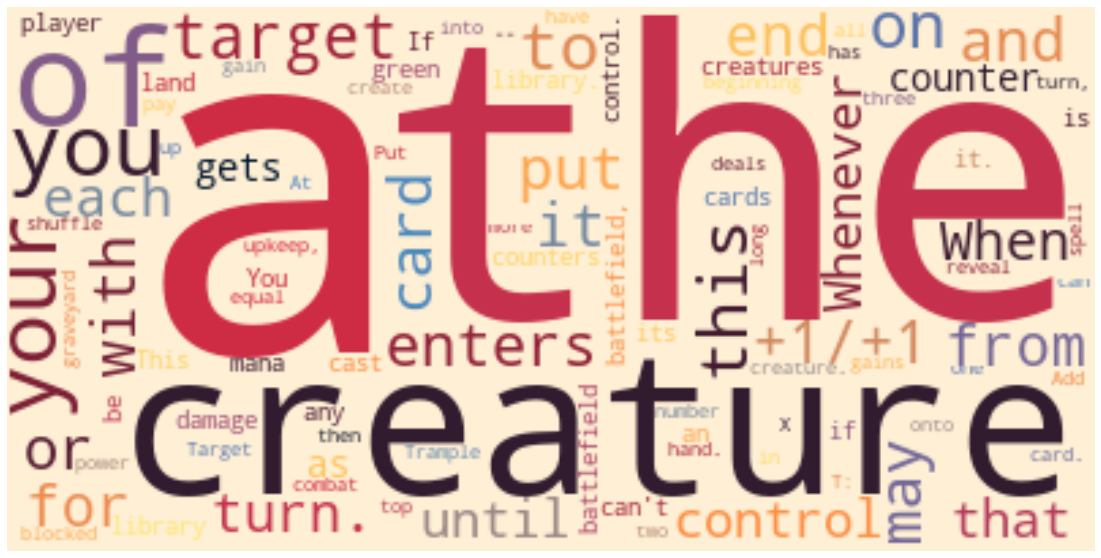

In [34]:
#Plot wordcloud image using the clean text column
hero.wordcloud(df.clean_text, max_words=100,)

In [35]:
import plotly.express as px

tw = hero.visualization.top_words(df['clean_text']).head(10)

fig = px.bar(tw)
fig.show()
tw.head()

creature    2589
a           2343
the         2339
of          2024
you         1802
Name: clean_text, dtype: int64

# Build Model

In [36]:
df.head(1)

,name,text,convertedManaCost,power,toughness,keywords,clean_text,tfidf,card2vec,tsnetfidf,tsnec2v,pca,kmeans_labels,DBSCAN_labels
0,Abundance,"If you would draw a card, you may instead choo...",4.0,None,None,None,"If you would draw a card, you may instead choo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0942135602235794, -0.20128001272678375, -0....","[21.94685935974121, 52.017738342285156]","[5.099956035614014, 48.88468551635742]","[0.3824110980473819, 0.18521850124281702]",2,-1


In [37]:
df[['text', 'clean_text', 'tfidf', 'card2vec', 'tsnetfidf', 'pca', 'kmeans_labels', 'DBSCAN_labels']].head(2)

,text,clean_text,tfidf,card2vec,tsnetfidf,pca,kmeans_labels,DBSCAN_labels
0,"If you would draw a card, you may instead choo...","If you would draw a card, you may instead choo...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0942135602235794, -0.20128001272678375, -0....","[21.94685935974121, 52.017738342285156]","[0.3824110980473819, 0.18521850124281702]",2,-1
1,Target creature gets +1/+1 until end of turn.\...,Target creature gets +1/+1 until end of turn. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02753867581486702, 0.016316216439008713, -...","[16.462970733642578, 26.85483169555664]","[-0.2920889673080659, 0.4995445900794637]",1,7


In [38]:
Ktrain_df = df[['tfidf', 'kmeans_labels']]
Dtrain_df = df[['tfidf', 'DBSCAN_labels']]

In [39]:
Ktrain_df.head(3)

,tfidf,kmeans_labels
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [40]:
Ktrain_df.kmeans_labels.unique()

array(['2', '1', '0'], dtype=object)

In [41]:
Ktrain_df.shape

(3165, 2)

In [42]:
vecs = Ktrain_df.tfidf.to_list()
vecs[:2]
vecs_df = pd.DataFrame(vecs)

In [43]:
vecs_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2960,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.186649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148631,0.0,0.188943,0.0,0.0,0.000000,0.0,0.215183,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282335,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.263821,0.0,0.000000,0.0


In [44]:
vecs_df.shape

(3165, 3000)

In [45]:
vecs_df['label'] = Ktrain_df['kmeans_labels']

In [46]:
vecs_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2961,2962,2963,2964,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.186649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148631,0.0,0.188943,0.0,0.0,0.0,0.0,0.215183,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282335,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1
